# Optimization For Data Science Project
#### ODS Final Project
Shehroz Ali, Alexandra Pilipyuk, Adriano Rasetta


---


### Methods for Deep Learning 
### Classification task: Fashion MNIST


### Libraries

In [ ]:
import os
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torch.nn import Sequential

### Dataset

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)


Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw




Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw




Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw




Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Datsets

print(train_dataset, "\n")
print(test_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: classifier_data
    Split: Train 

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: classifier_data
    Split: Test


Tuple: (<PIL.Image.Image image mode=L size=28x28 at 0x7F07F7279C50>, 9)

Image format: <PIL.Image.Image image mode=L size=28x28 at 0x7F07F7279E50>

Sample at index: 0

Label: 9

Image:



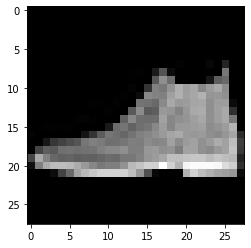

In [ ]:
# How to get an image (PIL image) and the corresponding label

sample_index = 0
image = test_dataset[sample_index][0]
label = test_dataset[sample_index][1]

fig = plt.figure(figsize=(4,4))
plt.imshow(image, cmap='gist_gray')
print(f"Tuple:", train_dataset[sample_index])
print(f"\nImage format:", train_dataset[sample_index][0])
print(f"\nSample at index: {sample_index}")
print(f"\nLabel: {label}")
print("\nImage:\n")

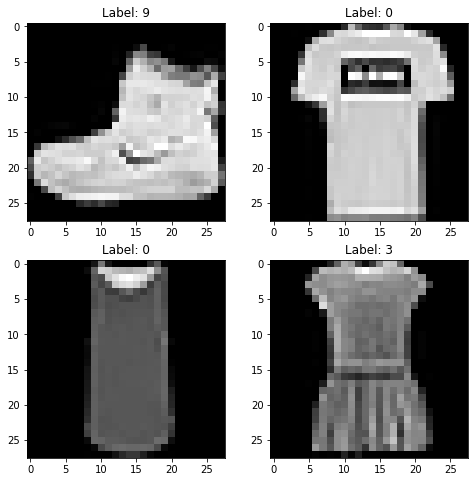

In [ ]:
# Some image samples

plt.figure(figsize=(8, 8))

for sample_index in range(4):
  im = train_dataset[sample_index][0]
  lab = train_dataset[sample_index][1]

  plt.subplot(2,2,sample_index+1)
  plt.title(f"Label: {lab}")
  plt.imshow(im, cmap='gist_gray')

In [ ]:
# Tensor transformation of all dataset

train_trans = transforms.ToTensor()
test_trans = transforms.ToTensor()

train_dataset.transform = train_trans
test_dataset.transform = test_trans

# Training set
print(f"\nTensor shape: {train_dataset[sample_index][0].shape}")
print(f"\nTensor label at index {sample_index}: {train_dataset[sample_index][1]}")

# Test Set
print(f"\nTensor shape:", test_dataset[sample_index][0].shape)
print(f"\nTensor label at index {sample_index}: {test_dataset[sample_index][1]}")


Tensor shape: torch.Size([1, 28, 28])

Tensor label at index 3: 3

Tensor shape: torch.Size([1, 28, 28])

Tensor label at index 3: 1


In [ ]:
# Split train (50000 samples) and validation set (10000 samples) 

torch.manual_seed(0)
train_dataset_new, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

print(f"Train set length: {len(train_dataset_new)}")
print(f"\nValidation set length: {len(val_dataset)}")
print(f"\nTest set length: {len(test_dataset)}")
print(f"\nWhole train set for the train of the best model: {len(train_dataset)}")

Train set length: 50000

Validation set length: 10000

Test set length: 10000

Whole train set for the train of the best model: 60000


In [ ]:
# Dataloader

train_dataloader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True,  num_workers=2)
train_dataloader_new = DataLoader(dataset=train_dataset_new, batch_size=50, shuffle=True,  num_workers=2)
validation_dataloader   = DataLoader(dataset=val_dataset,   batch_size=len(val_dataset),  shuffle=False, num_workers=2) 
test_dataloader  = DataLoader(dataset=test_dataset,  batch_size=len(test_dataset),  shuffle=False, num_workers=2)

In [ ]:
# Dimension exploration of dataloaders

# Train batch
image_batch, label_batch = next(iter(train_dataloader_new))
print(f"\nTrain input batch shape: {image_batch.shape}")
print(f"Train label batch shape: {label_batch.shape}")

# Validation batch
image_batch, label_batch = next(iter(validation_dataloader))
print(f"\nValidation input batch shape: {image_batch.shape}")
print(f"Validation label batch shape: {label_batch.shape}")

# Test batch
image_batch, label_batch = next(iter(test_dataloader))
print(f"\nTest input batch shape: {image_batch.shape}")
print(f"Test label batch shape: {label_batch.shape}")

# Train batch (Whole train set)
print("\nTrain batch of the train set for the best model:")
image_batch, label_batch = next(iter(train_dataloader))
print(f"Train input batch shape: {image_batch.shape}")
print(f"Train label batch shape: {label_batch.shape}")



Train input batch shape: torch.Size([50, 1, 28, 28])
Train label batch shape: torch.Size([50])

Validation input batch shape: torch.Size([10000, 1, 28, 28])
Validation label batch shape: torch.Size([10000])

Test input batch shape: torch.Size([10000, 1, 28, 28])
Test label batch shape: torch.Size([10000])

Train batch of the train set for the best model:
Train input batch shape: torch.Size([50, 1, 28, 28])
Train label batch shape: torch.Size([50])


### Model

In [ ]:
class Net(nn.Module):
    
    def __init__(self, Nh1 = 64, Nh2 = 64): # Structure of the network, definition of the structural parameters
        """
        Nh1 - Neurons in the first hidden layer
        Nh2 - Neurons in the second hidden layer
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=784, out_features=Nh1) # Input neurons 784 (28x28)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=10) # Output neurons 10 (classes)
        self.act = nn.ReLU(inplace=True)
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x): 
        x = self.act(self.fc1(x)) 
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

    
    def reset_weights(model):
        torch.manual_seed(0)
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

### Training and testing function

In [ ]:
# Training function

def train_function(model, device, train_dataloader, validation_dataloader, num_epochs, optimizer):
    """
    Input: model, device, train dataloader, validation dataloader, number of epochs, optimizer
    Output: list of (batch average) train losses (one for each epoch), list of (batch average) validation losses (one for each epoch)
    """
    torch.manual_seed(0)
    model.reset_weights() # Reset of the weights 
    loss_function = nn.CrossEntropyLoss() # Loss function
    
    train_loss_epochs = []
    accuracy_train_epochs = []
    
    val_loss_epochs = []
    accuracy_val_epochs = []

    for epoch_num in range(num_epochs):
      print(f'-> Epoch {epoch_num + 1}\n')

      # TRAIN
      train_loss= []
      accuracy_batch_train = []
      model.train() # Training mode 
      for sample_batched in train_dataloader:
        
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Batch sample reshaping
        x_batch = x_batch.view(50, 1, 784) # From [50, 1, 28, 28] to [50, 1, 784]

        # Forward pass
        out = model(x_batch)

        # Output reshaping
        out = out.view(50, 10)  # From [50, 1, 10] to [50, 10]

        # Compute loss
        loss = loss_function(out, label_batch) 

        # Backpropagation
        model.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step(lambda: float(loss))

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch) 

        # Prediction for training set
        softmax = torch.exp(out).cpu()
        prob = list(softmax.detach().numpy())
        predictions = np.argmax(prob, axis=1)

        # Save accuracy for this batch
        accuracy_batch_train.append(accuracy_score(label_batch.cpu(), predictions))

      # Save average train loss for this epoch
      train_loss = np.mean(train_loss) 
      print(f"Train loss: {train_loss}") 
      train_loss_epochs.append(train_loss) # List of the losses (= number of epochs) 

      # Save average accuracy for this epoch
      accuracy_batch_train = np.mean(accuracy_batch_train) 
      print(f"Accuracy on training set: {accuracy_batch_train}\n")
      accuracy_train_epochs.append(accuracy_batch_train) # List of the accuracies (= number of epochs) 
      

      # VALIDATION
      val_loss = []
      accuracy_batch_val = []
      model.eval()
      with torch.no_grad():
        for sample_batched in validation_dataloader: # If "batch_size=len(validation_dataset)" in validation_loder we have only one value (one iteration for the cycle)

            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Batch sample reshaping
            x_batch = x_batch.view(10000, 1, 784) # From [10000, 1, 28, 28] to [10000, 1, 784]

            # Forward pass
            out = model(x_batch)

            # Output reshaping
            out = out.view(10000, 10)  # From [10000, 1, 10] to [10000, 10]

            # Compute loss
            loss = loss_function(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

            # Prediction for validation set
            softmax = torch.exp(out).cpu()
            prob = list(softmax.detach().numpy())
            predictions = np.argmax(prob, axis=1)

            # Save accuracy for this batch
            accuracy_batch_val.append(accuracy_score(label_batch.cpu(), predictions))
      
        # Save average validation loss for this epoch
        val_loss = np.mean(val_loss) # Validation loss calculated after each epoch
        print(f"Validation loss: {val_loss}") 
        val_loss_epochs.append(val_loss)

        # Save average accuracy for this epoch
        accuracy_batch_val = np.mean(accuracy_batch_val) 
        print(f"Accuracy on validation set: {accuracy_batch_val}\n")
        accuracy_val_epochs.append(accuracy_batch_val) # List of the accuracies (= number of epochs) 

    return train_loss_epochs, accuracy_train_epochs, val_loss_epochs, accuracy_val_epochs

### Optimizers

#### Adam

In [ ]:
class Adam_optimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, beta_1=0.9, beta_2=0.999, eps=1e-8):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} < 0".format(lr))
        if not 0.0 <= beta_1 < 1.0:
            raise ValueError("Invalid parameter beta_1: {} not in [0; 1)".format(beta_1))
        if not 0.0 <= beta_2 < 1.0:
            raise ValueError("Invalid parameter beta_2: {} not in [0; 1)".format(beta_2))
        if eps < 0.0:
            raise ValueError("Invalid epsilon value: {} < 0".format(eps))

        defaults = dict(lr=lr, betas=(beta_1, beta_2), eps=eps)
        super(Adam_optimizer, self).__init__(params, defaults)

        for group in self.param_groups:
            for param in group["params"]:
                self.state[param]['step'] = 0
                self.state[param]['m'] = torch.zeros_like(param.data)
                self.state[param]['v'] = torch.zeros_like(param.data)

    def step(self, closure=None):
        for group in self.param_groups:
            for param in group["params"]:
                if param.grad is None:
                    continue

                grad = param.grad.data
                
                state = self.state[param]
                m = state['m']
                v = state['v']
                beta_1, beta_2 = group['betas']
                state['step'] += 1

                m = m * beta_1 + (1 - beta_1) * grad
                v = v * beta_2 + (1 - beta_2) * grad * grad

                m_hat = m / (1 - beta_1 ** state['step'])
                v_hat = v / (1 - beta_2 ** state['step'])

                param.data -= group['lr'] * m_hat / (v_hat.sqrt() + group['eps'])

                state['m'] = m
                state['v'] = v

        return None

#### Adagrad

In [ ]:
class AdaGrad_optimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, eps=1e-8):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} < 0".format(lr))
        if eps < 0.0:
            raise ValueError("Invalid epsilon value: {} < 0".format(eps))
            
        defaults = dict(lr=lr, eps=eps)
        super(AdaGrad_optimizer, self).__init__(params, defaults)

        for group in self.param_groups:
            for param in group["params"]:
                self.state[param]['step'] = 0
                self.state[param]['G'] = 0

    def step(self, closure=None):
        for group in self.param_groups:
            for param in group["params"]:
                if param.grad is None:
                    continue

                grad = param.grad.data
                
                state = self.state[param]
                state['G'] += grad * grad
                state['step'] += 1

                param.data -= group['lr'] * grad / (state['G'] + group['eps']).sqrt()

        return None

#### Deep Frank-Wolf

In [ ]:
class DFW_optimizer(optim.Optimizer):

    def __init__(self, params, eta, momentum=0.9, eps=1e-8):
        if eta <= 0.0:
            raise ValueError("Invalid eta: {} < 0".format(eta))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {} < 0".format(momentum))

        defaults = dict(eta=eta, momentum=momentum, eps=eps)
        super(DFW_optimizer, self).__init__(params, defaults)

        for group in self.param_groups:
            for param in group['params']:
                self.state[param]['z'] = torch.zeros_like(param.data)

    def step(self, closure):
        loss = float(closure())

        for group in self.param_groups:
            eta = group['eta']
            mu = group['momentum']
            eps = group['eps']

            for param in group['params']:
                if param.grad is None:
                    continue

                state = self.state[param]
                delta_t = param.grad.data

                gamma = loss / (eta * delta_t.norm() ** 2 + eps)
                if gamma > 1:
                    gamma = 1
                if gamma < 0:
                    gamma = 0

                z = state['z']
                z = mu * z - eta * gamma * delta_t

                param.data += mu * z - eta * gamma * delta_t

### Optimizers tuning: grid searches

#### Adam grid search

In [ ]:
# Dict of lists of hyperparameters Adam (We consider only one hyperparameter, the betas are almost always fixed values)

hyperparam_grid_Adam = {"lr": [0.01, 0.001, 0.0001]}



##### MODEL: 1/3 #####


Hyperparameters combination:
 {'lr': 0.01}
-> Epoch 1

Train loss: 0.684918224811554
Accuracy on training set: 0.75072

Validation loss: 0.4937877953052521
Accuracy on validation set: 0.8179

-> Epoch 2

Train loss: 0.5933801531791687
Accuracy on training set: 0.7888000000000001

Validation loss: 0.5075778961181641
Accuracy on validation set: 0.8083

-> Epoch 3

Train loss: 0.5792801380157471
Accuracy on training set: 0.79872

Validation loss: 0.44844815135002136
Accuracy on validation set: 0.8336

-> Epoch 4

Train loss: 0.5736225247383118
Accuracy on training set: 0.7985

Validation loss: 0.472243994474411
Accuracy on validation set: 0.8261

-> Epoch 5

Train loss: 0.565217912197113
Accuracy on training set: 0.80122

Validation loss: 0.4454600512981415
Accuracy on validation set: 0.8347

-> Epoch 6

Train loss: 0.5610831379890442
Accuracy on training set: 0.80578

Validation loss: 0.45057743787765503
Accuracy on validation set: 0.8418

-> Epoch 7

Train los

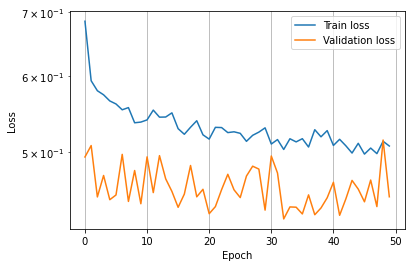

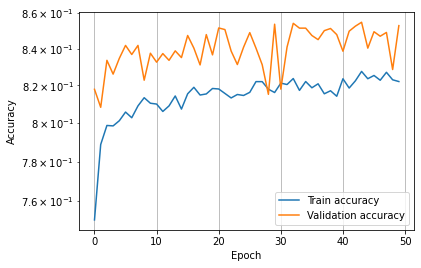



##### MODEL: 2/3 #####


Hyperparameters combination:
 {'lr': 0.001}
-> Epoch 1

Train loss: 0.7074968218803406
Accuracy on training set: 0.74878

Validation loss: 0.4635807275772095
Accuracy on validation set: 0.8335

-> Epoch 2

Train loss: 0.4786392152309418
Accuracy on training set: 0.83142

Validation loss: 0.4109913110733032
Accuracy on validation set: 0.8497

-> Epoch 3

Train loss: 0.4346620440483093
Accuracy on training set: 0.84316

Validation loss: 0.3998740613460541
Accuracy on validation set: 0.8506

-> Epoch 4

Train loss: 0.4083430767059326
Accuracy on training set: 0.8526800000000001

Validation loss: 0.3691810071468353
Accuracy on validation set: 0.8641

-> Epoch 5

Train loss: 0.39540332555770874
Accuracy on training set: 0.8563800000000001

Validation loss: 0.3542231321334839
Accuracy on validation set: 0.8691

-> Epoch 6

Train loss: 0.37802359461784363
Accuracy on training set: 0.8627999999999999

Validation loss: 0.3508290946483612
Accuracy on validation set: 0.

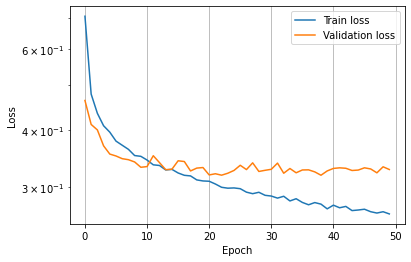

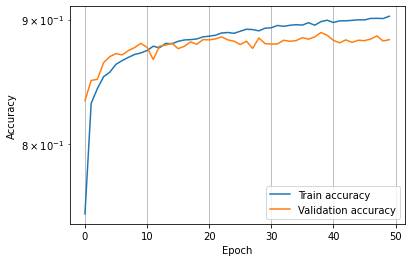



##### MODEL: 3/3 #####


Hyperparameters combination:
 {'lr': 0.0001}
-> Epoch 1

Train loss: 1.2486189603805542
Accuracy on training set: 0.5663599999999999

Validation loss: 0.7552815079689026
Accuracy on validation set: 0.7128

-> Epoch 2

Train loss: 0.7615350484848022
Accuracy on training set: 0.72582

Validation loss: 0.6128435730934143
Accuracy on validation set: 0.7751

-> Epoch 3

Train loss: 0.6475914716720581
Accuracy on training set: 0.7715000000000001

Validation loss: 0.5388962626457214
Accuracy on validation set: 0.8051

-> Epoch 4

Train loss: 0.5803989768028259
Accuracy on training set: 0.79874

Validation loss: 0.5012778043746948
Accuracy on validation set: 0.8184

-> Epoch 5

Train loss: 0.539166271686554
Accuracy on training set: 0.8113400000000001

Validation loss: 0.4729151427745819
Accuracy on validation set: 0.8279

-> Epoch 6

Train loss: 0.5086700916290283
Accuracy on training set: 0.82398

Validation loss: 0.45533862709999084
Accuracy on validation set: 0.8

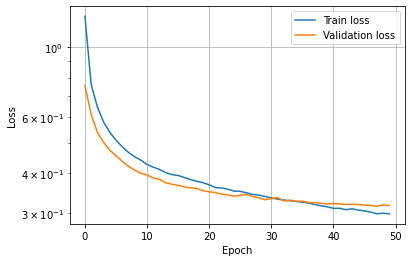

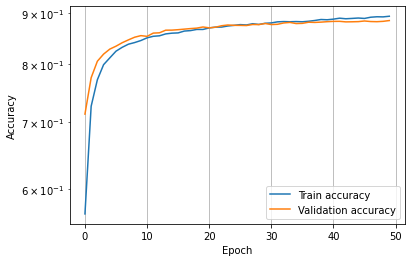

In [ ]:
# Adam grid search

combinations_dict_Adam = ParameterGrid(hyperparam_grid_Adam) # Combinations dict
scores_hyperpar_Adam = [] # List of tuples with the score of the model and the set of hyperparameters for that score
number_combinations = 3 # Number of the all combinations (3)
model_number = 1 # Counter for the grid search

for hyperparam_combination in combinations_dict_Adam:

  model_Adam = Net()
  model_Adam_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
  model_Adam.to(model_Adam_device)
  optimizer = Adam_optimizer(model_Adam.parameters(), lr = hyperparam_combination["lr"])
  num_epochs = 50

  print(f"\n\n##### MODEL: {model_number}/{number_combinations} #####\n")
  print("\nHyperparameters combination:\n", hyperparam_combination)
  model_number += 1
  train_loss, accuracy_train_scores, validation_loss, accuracy_val_scores = train_function(model_Adam, model_Adam_device, train_dataloader_new, validation_dataloader, num_epochs, optimizer)
  print("\n\n\nFINAL RESULT:")
  print(f"Final loss on validation set: {validation_loss[-1]}")
  print(f"Final accuracy on validation set: {accuracy_val_scores[-1]}")

  # Plot of losses and accuracies
  print("Plot of train and validation loss:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(train_loss, label='Train loss')
  plt.semilogy(validation_loss, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

  print("Plot of train and validation accuracy:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(accuracy_train_scores, label='Train accuracy')
  plt.semilogy(accuracy_val_scores, label='Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()

  plt.show()

  scores_hyperpar_Adam.append((validation_loss[-1], accuracy_val_scores[-1], hyperparam_combination)) # Last validation, last accuracy and hyperparameters

In [ ]:
# Best model Adam (we consider the best accuracy)

best_score_validation_Adam = max(scores_hyperpar_Adam, key=operator.itemgetter(1))[0]
best_score_accuracy_Adam = max(scores_hyperpar_Adam, key=operator.itemgetter(1))[1]
best_hyperpars_Adam = max(scores_hyperpar_Adam, key=operator.itemgetter(1))[2]
print("Best validation and accuracy score:\n", best_score_validation_Adam, best_score_accuracy_Adam)
print("\nBest hyperparameters:\n", best_hyperpars_Adam)

Best validation and accuracy score:
 0.31741315 0.8842

Best hyperparameters:
 {'lr': 0.0001}


#### AdaGrad grid search

In [ ]:
# Dict of lists of hyperparameters AdaGrad

hyperparam_grid_AdaGrad = {"lr": [0.01, 0.001, 0.0001]}



##### MODEL: 1/3 #####


Hyperparameters combination:
 {'lr': 0.01}
-> Epoch 1

Train loss: 0.7219301462173462
Accuracy on training set: 0.7379

Validation loss: 0.5041198134422302
Accuracy on validation set: 0.8177

-> Epoch 2

Train loss: 0.539718508720398
Accuracy on training set: 0.8125

Validation loss: 0.4544408619403839
Accuracy on validation set: 0.8361

-> Epoch 3

Train loss: 0.5018988251686096
Accuracy on training set: 0.8244000000000001

Validation loss: 0.4300534725189209
Accuracy on validation set: 0.8419

-> Epoch 4

Train loss: 0.4800418019294739
Accuracy on training set: 0.8313200000000002

Validation loss: 0.41710761189460754
Accuracy on validation set: 0.8492

-> Epoch 5

Train loss: 0.46567875146865845
Accuracy on training set: 0.8363400000000001

Validation loss: 0.4127019941806793
Accuracy on validation set: 0.8484

-> Epoch 6

Train loss: 0.4504382312297821
Accuracy on training set: 0.84194

Validation loss: 0.40008896589279175
Accuracy on validation set: 0.854

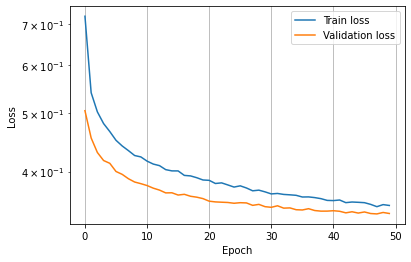

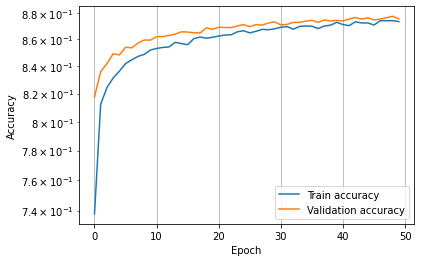



##### MODEL: 2/3 #####


Hyperparameters combination:
 {'lr': 0.001}
-> Epoch 1

Train loss: 1.2556756734848022
Accuracy on training set: 0.56704

Validation loss: 0.8877066373825073
Accuracy on validation set: 0.682

-> Epoch 2

Train loss: 0.9331554174423218
Accuracy on training set: 0.6592199999999999

Validation loss: 0.7793314456939697
Accuracy on validation set: 0.7165

-> Epoch 3

Train loss: 0.852068305015564
Accuracy on training set: 0.69012

Validation loss: 0.7266530394554138
Accuracy on validation set: 0.7329

-> Epoch 4

Train loss: 0.8028422594070435
Accuracy on training set: 0.7115799999999999

Validation loss: 0.6932364702224731
Accuracy on validation set: 0.7444

-> Epoch 5

Train loss: 0.7674378752708435
Accuracy on training set: 0.72246

Validation loss: 0.6665960550308228
Accuracy on validation set: 0.7581

-> Epoch 6

Train loss: 0.7408482432365417
Accuracy on training set: 0.7382000000000001

Validation loss: 0.645822286605835
Accuracy on validation set: 0.7663


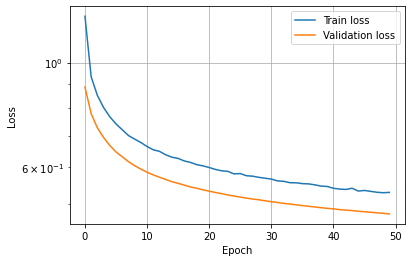

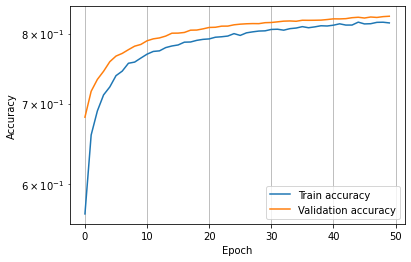



##### MODEL: 3/3 #####


Hyperparameters combination:
 {'lr': 0.0001}
-> Epoch 1

Train loss: 2.1870980262756348
Accuracy on training set: 0.29856000000000005

Validation loss: 2.100585460662842
Accuracy on validation set: 0.4164

-> Epoch 2

Train loss: 2.055673837661743
Accuracy on training set: 0.37746

Validation loss: 1.9857850074768066
Accuracy on validation set: 0.4501

-> Epoch 3

Train loss: 1.9625712633132935
Accuracy on training set: 0.41344

Validation loss: 1.893534541130066
Accuracy on validation set: 0.4755

-> Epoch 4

Train loss: 1.884382963180542
Accuracy on training set: 0.43528

Validation loss: 1.8143302202224731
Accuracy on validation set: 0.4992

-> Epoch 5

Train loss: 1.8174546957015991
Accuracy on training set: 0.4587

Validation loss: 1.7455517053604126
Accuracy on validation set: 0.5204

-> Epoch 6

Train loss: 1.7577813863754272
Accuracy on training set: 0.47422000000000003

Validation loss: 1.6845253705978394
Accuracy on validation set: 0.543

-> Epoch 7

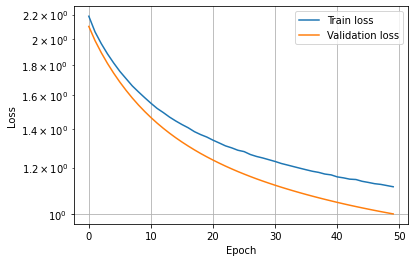

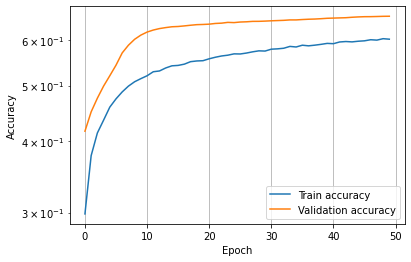

In [ ]:
# AdaGrad grid search

combinations_dict_AdaGrad = ParameterGrid(hyperparam_grid_AdaGrad) # Combinations dict
scores_hyperpar_AdaGrad = [] # List of tuples with the score of the model and the set of hyperparameters for that score
number_combinations = 3 # Number of the all combinations (3)
model_number = 1 # Counter for the grid search

for hyperparam_combination in combinations_dict_AdaGrad:

  model_AdaGrad = Net()
  model_AdaGrad_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
  model_AdaGrad.to(model_AdaGrad_device)
  optimizer = AdaGrad_optimizer(model_AdaGrad.parameters(), lr = hyperparam_combination["lr"])
  num_epochs = 50

  print(f"\n\n##### MODEL: {model_number}/{number_combinations} #####\n")
  print("\nHyperparameters combination:\n", hyperparam_combination)
  model_number += 1
  train_loss, accuracy_train_scores, validation_loss, accuracy_val_scores = train_function(model_AdaGrad, model_AdaGrad_device, train_dataloader_new, validation_dataloader, num_epochs, optimizer)
  print("\n\n\nFINAL RESULT:")
  print(f"Final loss on validation set: {validation_loss[-1]}")
  print(f"Final accuracy on validation set: {accuracy_val_scores[-1]}")

  # Plot of losses and accuracies
  print("Plot of train and validation loss:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(train_loss, label='Train loss')
  plt.semilogy(validation_loss, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

  print("Plot of train and validation accuracy:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(accuracy_train_scores, label='Train accuracy')
  plt.semilogy(accuracy_val_scores, label='Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()

  plt.show()

  scores_hyperpar_AdaGrad.append((validation_loss[-1], accuracy_val_scores[-1], hyperparam_combination)) # Last validation, last accuracy and hyperparameters

In [ ]:
# Best model AdaGrad (we consider the best accuracy)

best_score_validation_AdaGrad = max(scores_hyperpar_AdaGrad, key=operator.itemgetter(1))[0]
best_score_accuracy_AdaGrad = max(scores_hyperpar_AdaGrad, key=operator.itemgetter(1))[1]
best_hyperpars_AdaGrad = max(scores_hyperpar_AdaGrad, key=operator.itemgetter(1))[2]
print("Best validation and accuracy score:\n", best_score_validation_AdaGrad, best_score_accuracy_AdaGrad)
print("\nBest hyperparameters:\n", best_hyperpars_AdaGrad)

Best validation and accuracy score:
 0.34103626 0.8756

Best hyperparameters:
 {'lr': 0.01}


#### Deep Frank-Wolf grid search

In [ ]:
# Dict of lists of hyperparameters DFW

hyperparam_grid_DFW = {"eta":[0.01, 0.001, 0.0001]}



##### MODEL: 1/3 #####


Hyperparameters combination:
 {'eta': 0.01}
-> Epoch 1

Train loss: 1.233381748199463
Accuracy on training set: 0.5521

Validation loss: 0.724008321762085
Accuracy on validation set: 0.7297

-> Epoch 2

Train loss: 0.7220464944839478
Accuracy on training set: 0.74002

Validation loss: 0.5827592611312866
Accuracy on validation set: 0.7842

-> Epoch 3

Train loss: 0.6153140664100647
Accuracy on training set: 0.7833600000000001

Validation loss: 0.5090795159339905
Accuracy on validation set: 0.813

-> Epoch 4

Train loss: 0.5522294640541077
Accuracy on training set: 0.8079400000000001

Validation loss: 0.4704231917858124
Accuracy on validation set: 0.8278

-> Epoch 5

Train loss: 0.5141621232032776
Accuracy on training set: 0.8186

Validation loss: 0.453705370426178
Accuracy on validation set: 0.8326

-> Epoch 6

Train loss: 0.48917627334594727
Accuracy on training set: 0.8285600000000002

Validation loss: 0.4282519519329071
Accuracy on validation set: 0.8439

-

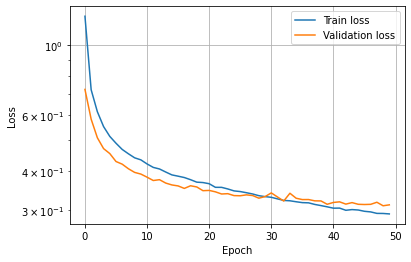

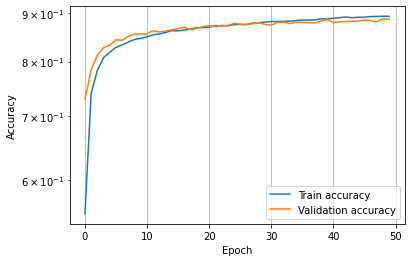



##### MODEL: 2/3 #####


Hyperparameters combination:
 {'eta': 0.001}
-> Epoch 1

Train loss: 2.215672254562378
Accuracy on training set: 0.23266000000000003

Validation loss: 2.0693540573120117
Accuracy on validation set: 0.3813

-> Epoch 2

Train loss: 1.853201150894165
Accuracy on training set: 0.40144

Validation loss: 1.547291874885559
Accuracy on validation set: 0.58

-> Epoch 3

Train loss: 1.4360558986663818
Accuracy on training set: 0.50312

Validation loss: 1.1833964586257935
Accuracy on validation set: 0.6326

-> Epoch 4

Train loss: 1.19693922996521
Accuracy on training set: 0.56082

Validation loss: 1.001582145690918
Accuracy on validation set: 0.6562

-> Epoch 5

Train loss: 1.0600603818893433
Accuracy on training set: 0.60122

Validation loss: 0.8989326357841492
Accuracy on validation set: 0.6746

-> Epoch 6

Train loss: 0.9739851951599121
Accuracy on training set: 0.63106

Validation loss: 0.8349466919898987
Accuracy on validation set: 0.6887

-> Epoch 7

Train loss: 

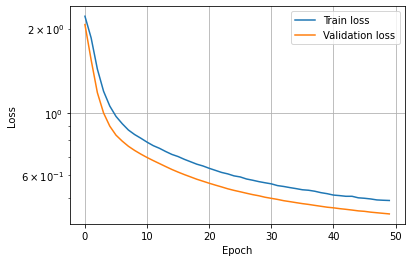

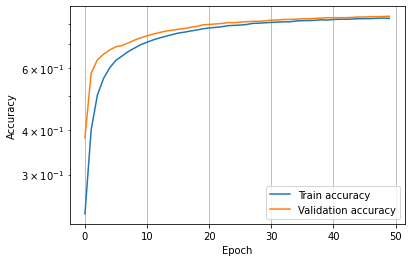



##### MODEL: 3/3 #####


Hyperparameters combination:
 {'eta': 0.0001}
-> Epoch 1

Train loss: 2.3018431663513184
Accuracy on training set: 0.1245

Validation loss: 2.2939302921295166
Accuracy on validation set: 0.1503

-> Epoch 2

Train loss: 2.284599542617798
Accuracy on training set: 0.15360000000000001

Validation loss: 2.2768516540527344
Accuracy on validation set: 0.1677

-> Epoch 3

Train loss: 2.2686612606048584
Accuracy on training set: 0.17710000000000004

Validation loss: 2.2594475746154785
Accuracy on validation set: 0.1867

-> Epoch 4

Train loss: 2.251298427581787
Accuracy on training set: 0.20804000000000003

Validation loss: 2.2410995960235596
Accuracy on validation set: 0.2566

-> Epoch 5

Train loss: 2.2333836555480957
Accuracy on training set: 0.22972000000000004

Validation loss: 2.2208263874053955
Accuracy on validation set: 0.326

-> Epoch 6

Train loss: 2.212700843811035
Accuracy on training set: 0.25833999999999996

Validation loss: 2.1973323822021484
Accuracy

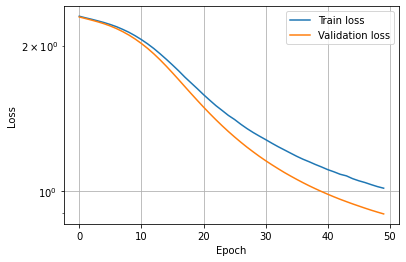

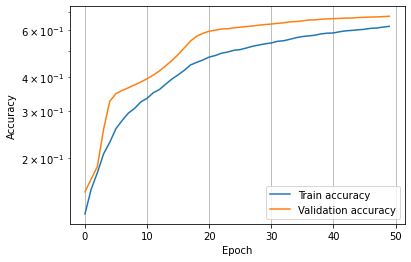

In [ ]:
# DFW grid search

combinations_dict_DFW = ParameterGrid(hyperparam_grid_DFW) # Combinations dict
scores_hyperpar_DFW = [] # List of tuples with the score of the model and the set of hyperparameters for that score
number_combinations = 3 # Number of the all combinations ()
model_number = 1 # Counter for the grid search

for hyperparam_combination in combinations_dict_DFW:

  model_DFW = Net()
  model_DFW_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
  model_DFW.to(model_DFW_device)
  optimizer = DFW_optimizer(model_DFW.parameters(), eta = hyperparam_combination["eta"])
  num_epochs = 50

  print(f"\n\n##### MODEL: {model_number}/{number_combinations} #####\n")
  print("\nHyperparameters combination:\n", hyperparam_combination)
  model_number += 1
  train_loss, accuracy_train_scores, validation_loss, accuracy_val_scores = train_function(model_DFW, model_DFW_device, train_dataloader_new, validation_dataloader, num_epochs, optimizer)
  print("\n\n\nFINAL RESULT:")
  print(f"Final loss on validation set: {validation_loss[-1]}")
  print(f"Final accuracy on validation set: {accuracy_val_scores[-1]}")

  # Plot of losses and accuracies
  print("Plot of train and validation loss:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(train_loss, label='Train loss')
  plt.semilogy(validation_loss, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

  print("Plot of train and validation accuracy:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(accuracy_train_scores, label='Train accuracy')
  plt.semilogy(accuracy_val_scores, label='Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()

  plt.show()

  scores_hyperpar_DFW.append((validation_loss[-1], accuracy_val_scores[-1], hyperparam_combination)) # Last validation, last accuracy and hyperparameters

In [ ]:
# Best model DFW (we consider the best accuracy)

best_score_validation_DFW = max(scores_hyperpar_DFW, key=operator.itemgetter(1))[0]
best_score_accuracy_DFW = max(scores_hyperpar_DFW, key=operator.itemgetter(1))[1]
best_hyperpars_DFW = max(scores_hyperpar_DFW, key=operator.itemgetter(1))[2]
print("Best validation and accuracy score:\n", best_score_validation_DFW, best_score_accuracy_DFW)
print("\nBest hyperparameters:\n", best_hyperpars_DFW)

Best validation and accuracy score:
 0.3123355 0.8871

Best hyperparameters:
 {'eta': 0.01}


### Final testing and comparison

In [ ]:
# Training on the entire training dataset and testing on test set

# List with optimizer name
optimizers_list = ["Adam", "AdaGrad", "DFW"]

# Epochs
num_epochs = 100

# Dict with the lists of losses (train and test) and accuracies (train and test)
Adam_dict = {"train_losses": [], "accuracy_train_scores":[], "test_losses":[], "accuracy_test_scores":[]}
AdaGrad_dict = {"train_losses": [], "accuracy_train_scores":[], "test_losses":[], "accuracy_test_scores":[]}
DFW_dict = {"train_losses": [], "accuracy_train_scores":[], "test_losses":[], "accuracy_test_scores":[]}

for name in optimizers_list:
  
  if name == "Adam":

    final_model_Adam = Net()
    final_model_Adam_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
    final_model_Adam.to(final_model_Adam_device)
    optimizer = Adam_optimizer(final_model_Adam.parameters(), lr = best_hyperpars_Adam["lr"])

    print("\n\n##### OPTIMIZER:", name, "#####\nTRAINING/TESTING\n")
    # Now we will use all the  train dataset and obviously the test dataloader instead of validation one
    Adam_dict["train_losses"], Adam_dict["accuracy_train_scores"], Adam_dict["test_losses"], Adam_dict["accuracy_test_scores"] = train_function(final_model_Adam, final_model_Adam_device, train_dataloader, test_dataloader, num_epochs, optimizer)


  if name == "AdaGrad":

    final_model_AdaGrad = Net()
    final_model_AdaGrad_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
    final_model_AdaGrad.to(final_model_AdaGrad_device)
    optimizer = AdaGrad_optimizer(final_model_AdaGrad.parameters(), lr = best_hyperpars_AdaGrad["lr"])

    print("\n\n##### OPTIMIZER:", name, "#####\nTRAINING/TESTING\n")
    # Now we will use all the  train dataset and obviously the test dataloader instead of validation one
    AdaGrad_dict["train_losses"], AdaGrad_dict["accuracy_train_scores"], AdaGrad_dict["test_losses"], AdaGrad_dict["accuracy_test_scores"] = train_function(final_model_AdaGrad, final_model_AdaGrad_device, train_dataloader, test_dataloader, num_epochs, optimizer)


  if name == "DFW":

    final_model_DFW = Net()
    final_model_DFW_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
    final_model_DFW.to(final_model_DFW_device)
    optimizer = DFW_optimizer(final_model_DFW.parameters(), eta = best_hyperpars_DFW["eta"])

    print("\n\n##### OPTIMIZER:", name, "#####\nTRAINING/TESTING\n")
    # Now we will use all the  train dataset and obviously the test dataloader instead of validation one
    DFW_dict["train_losses"], DFW_dict["accuracy_train_scores"], DFW_dict["test_losses"], DFW_dict["accuracy_test_scores"] = train_function(final_model_DFW, final_model_DFW_device, train_dataloader, test_dataloader, num_epochs, optimizer)


print("\n\n\nFINAL RESULTS FOR EACH OPTIMIZER\n\n")
print("Adam test loss:", Adam_dict["test_losses"][-1],"\n", "Adam test accuracy:", Adam_dict["accuracy_test_scores"][-1], "\n\n")
print("AdaGrad test loss:", AdaGrad_dict["test_losses"][-1],"\n", "AdaGrad test accuracy:", AdaGrad_dict["accuracy_test_scores"][-1], "\n\n")
print("DFW test loss:", DFW_dict["test_losses"][-1],"\n", "DFW test accuracy:", DFW_dict["accuracy_test_scores"][-1], "\n\n")



##### OPTIMIZER: Adam #####
TRAINING/TESTING

-> Epoch 1

Train loss: 1.169538140296936
Accuracy on training set: 0.5916166666666667

Validation loss: 0.7230991125106812
Accuracy on validation set: 0.7327

-> Epoch 2

Train loss: 0.7216721773147583
Accuracy on training set: 0.7409166666666666

Validation loss: 0.5980106592178345
Accuracy on validation set: 0.7881

-> Epoch 3

Train loss: 0.615969717502594
Accuracy on training set: 0.7821499999999999

Validation loss: 0.5354870557785034
Accuracy on validation set: 0.8135

-> Epoch 4

Train loss: 0.5566962957382202
Accuracy on training set: 0.8071166666666666

Validation loss: 0.49698296189308167
Accuracy on validation set: 0.8237

-> Epoch 5

Train loss: 0.5194318890571594
Accuracy on training set: 0.8197833333333334

Validation loss: 0.47272422909736633
Accuracy on validation set: 0.8332

-> Epoch 6

Train loss: 0.49251002073287964
Accuracy on training set: 0.8285333333333333

Validation loss: 0.4564380347728729
Accuracy on validatio

### Comparison plots of accuracy and loss 

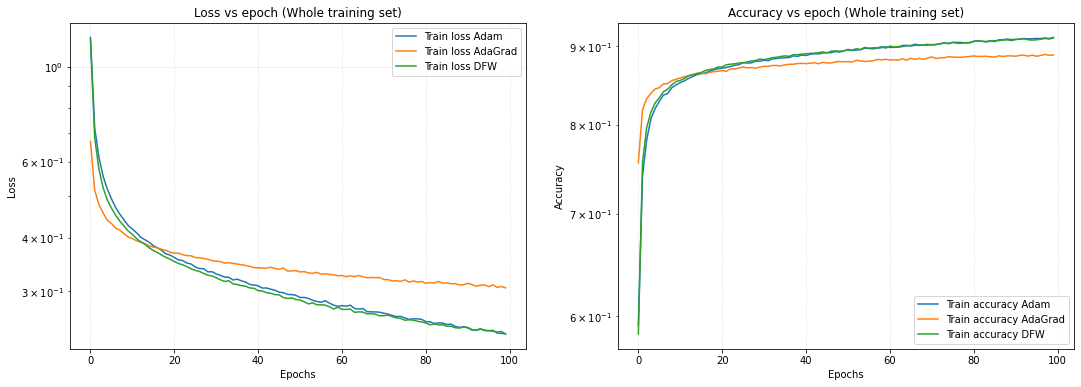

In [ ]:
# We use the train losses and the train accuracy scores
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(18,6))
dict_list = [("Adam", Adam_dict), ("AdaGrad", AdaGrad_dict), ("DFW", DFW_dict)]

# Titles
ax1.set_title(f"Loss vs epoch (Whole training set)")    
ax2.set_title(f"Accuracy vs epoch (Whole training set)")

for name, opt_dict in dict_list:

  # Plots
  ax1.semilogy(opt_dict["train_losses"], label=f'Train loss {name}')
  ax2.semilogy(opt_dict["accuracy_train_scores"], label=f'Train accuracy {name}')

  # Grid, labels and legends
  ax1.grid(color='lightgrey' , linestyle=':')
  ax2.grid(color='lightgrey' , linestyle=':')

  ax1.set_xlabel("Epochs")
  ax2.set_xlabel("Epochs")

  ax1.set_ylabel("Loss")
  ax2.set_ylabel("Accuracy")
      
  ax1.legend()
  ax2.legend()

  fig.show()